In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [2]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(z)
    x = LeakyReLU()(x)
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(img_size[-1],(3,3),strides=(2,2),padding="same")(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(latent_dim[-1],(3,3),strides=(2,2),padding="same")(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(128, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [3]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [4]:
data_folder = "sample_data/"
img_dim = 32
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2026 files belonging to 1 classes.
Metal device set to: Apple M2


2023-03-22 23:40:55.926915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 23:40:55.927029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [6]:
latent_dim = (2,2,32)
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
e_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
d_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)


In [7]:
num = len(train_ds)

train_ds = train_ds.map(apply_norm)
train_ds = tfds.as_numpy(train_ds)

z_train = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")

In [8]:
import random

t = list(zip(train_ds, z_train))
random.shuffle(t)
train_ds, z_train = zip(*t)

train_ds = np.array(train_ds)
z_train = np.array(z_train)

2023-03-22 23:40:56.203812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
epochs = 1
batch_size = 1

In [9]:
X_train = train_ds.reshape(-1, batch_size, img_dim, img_dim, 3)
z_train = z_train.reshape(-1, batch_size, latent_dim[0], latent_dim[1], latent_dim[2])

In [11]:
for epoch in tqdm(range(epochs), desc='Total'):
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    for steps in tqdm(range(0, num_steps//4)):
        x_batch = X_train[steps]
        z_batch = z_train[steps]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(-pred_enc))
            disc_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen)) + tf.reduce_mean(tf.nn.softplus(pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

[0] Desc loss : 357.5978380040	 Gen Loss : 1374.3452032206	 Enc Loss : 3108.9826383286


1/1 [==============================] - 0s 6ms/step


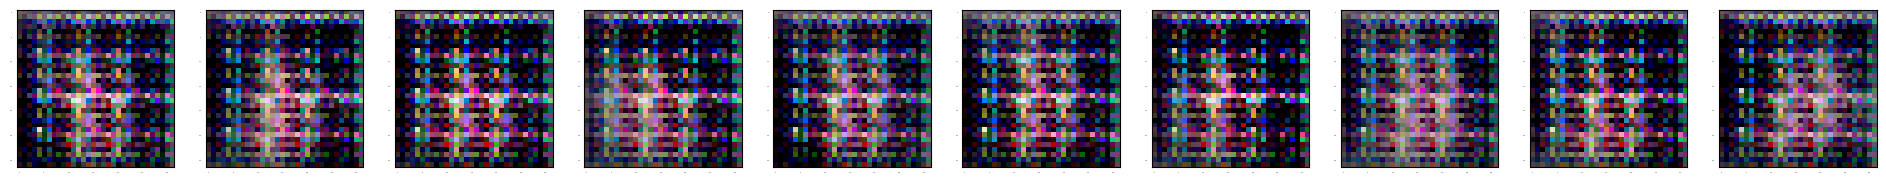

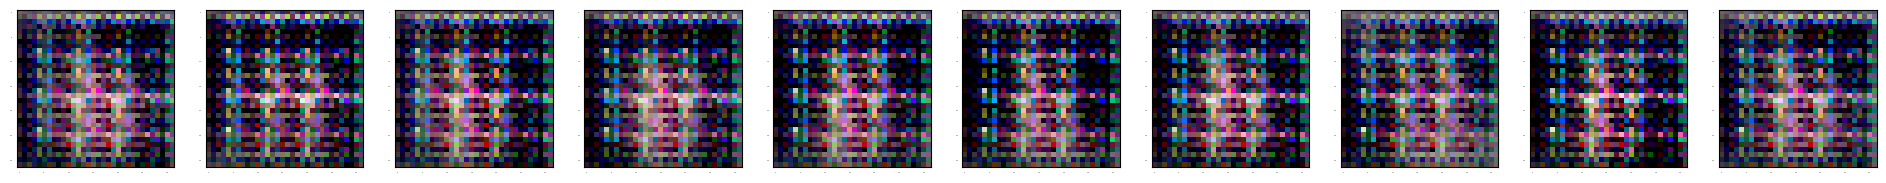

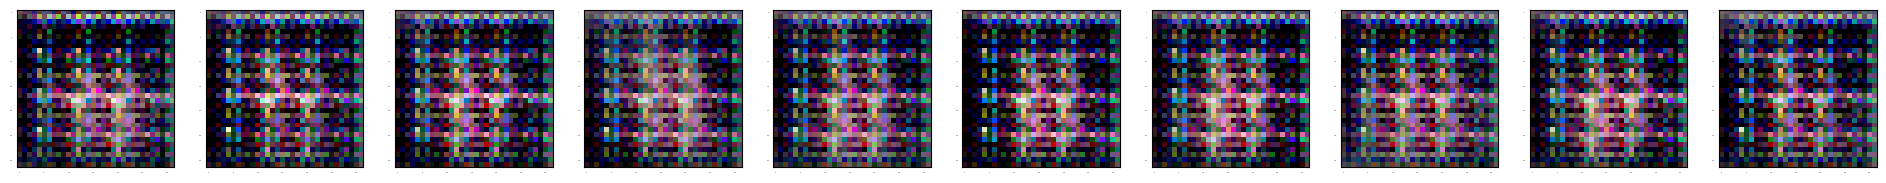

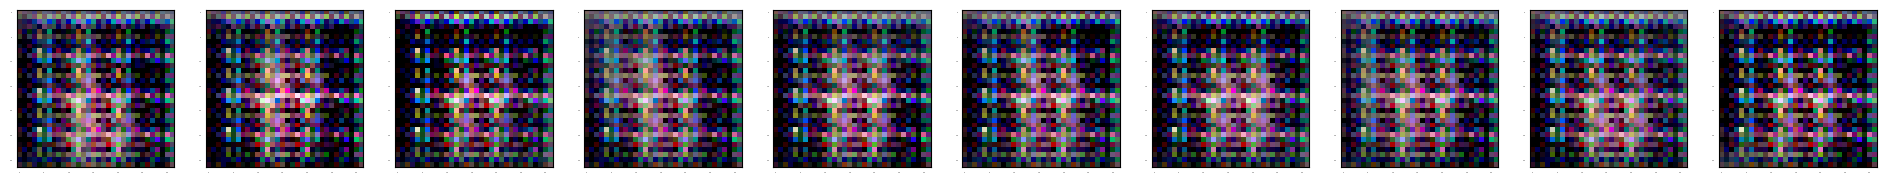

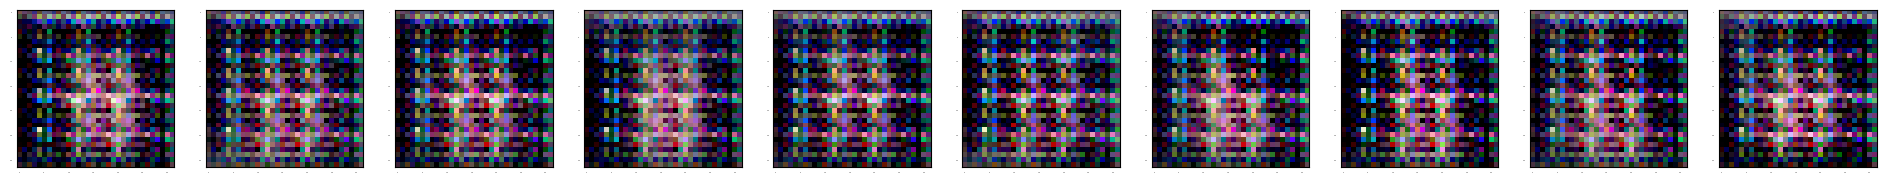

In [13]:
for _ in range(5):
    num_sample = 10
    z_test = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(1,num_sample, figsize=(24,12))
    for i in range(num_sample):
        axs[i].imshow(np.clip((pred[i]+1)*(1/2), 0, 1), cmap = 'gray')
        axs[i].tick_params(length=0, labelsize=0)